In [2]:
import torch 
from torch import nn

# 每一个单词使用100维度的向量表示  语境信息向量使用10维度 起始也是特征提取之后的单词向量的维度
rnn = nn.RNN(100,10)
print(rnn._parameters.keys())

odict_keys(['weight_ih_l0', 'weight_hh_l0', 'bias_ih_l0', 'bias_hh_l0'])


In [3]:
rnn.weight_hh_l0.shape,rnn.weight_ih_l0.shape
# 打印的是 whh权重 就是 10 x 10 后面一个是wxh向量 也就是[100,10] 下面写的是转置向量

(torch.Size([10, 10]), torch.Size([10, 100]))

In [4]:
rnn.bias_hh_l0.shape,rnn.bias_ih_l0.shape

(torch.Size([10]), torch.Size([10]))

In [7]:
# RNN创建
rnn = nn.RNN(input_size = 100,hidden_size = 20,num_layers=1)
print(rnn)

#  10代表每一个句子的单词数量  3代表三个句子  100 代表每一个单词的维度
x = torch.randn(10,3,100)

#  第一个参数是输入向量x 第二个参数是h向量  只有一个单词 每一层三个句子 每一个单词使用20个维度
out,h = rnn(x,torch.zeros(1,3,20))

# 最后的输出out 是一个 10 x 3 x 20 的向量 也就是被提取成20个维度  然后h是一个1 3 20的向量
print(out.shape,h.shape)



RNN(100, 20)
torch.Size([10, 3, 20]) torch.Size([1, 3, 20])


In [9]:
rnn = nn.RNN(input_size = 100,hidden_size = 20,num_layers = 4)
print(rnn)

x = torch.randn(10,3,100)

# 这里面的h 是多层的 应该是[4,3,20]
out,h = rnn(x)

print(out.shape,h.shape)

RNN(100, 20, num_layers=4)
torch.Size([10, 3, 20]) torch.Size([4, 3, 20])


In [10]:

#  100代表输入得特征维度  20代表提取的特征维度
cell = nn.RNNCell(100,20)

# 初始化输入  某一个时刻得输入
x = torch.randn(3,100)

# 初始化所有时刻得输入
xs = [torch.randn(3,100) for i in range(10)]

# 初始化隐藏层记忆单元
h = torch.zeros(3,20)


#  针对每一个时刻得输入 传入RNN单元
for xt in xs:
    h = cell(xt,h)

# 查看最后的输出
print(h.shape)


torch.Size([3, 20])


In [11]:

#  定义两层计算单元
cell_l0 = nn.RNNCell(100,30)
cell_l1 = nn.RNNCell(30,20)


# 定义两层的隐藏单元
h_l0 = torch.zeros(3,30)
h_l1 = torch.zeros(3,20)


# 初始化原始输入
xs = [torch.randn(3,100) for i in range(4)]

for xt in xs:
    h_l0 = cell_l0(xt,h_l0)
    h_l1 = cell_l1(h_l0,h_l1)


print(h_l0.shape)
print(h_l1.shape)

torch.Size([3, 30])
torch.Size([3, 20])


In [12]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        # RNN
        self.rnn = nn.RNN(
            input_size = 1, # feature_len = 1
            hidden_size = 16, # 隐藏层记忆单元尺寸
            num_layers = 1,# 层数
            batch_first = True  # 确保输入时 按照[batch,seq_len,feature_len]的模式 1 x 50 x 1
        )

        #  对RNN 进行参数初始化
        for p in self.rnn.parameters():
            nn.init.normal_(p,mean=0.0,std=0.001)

        #  输出层 直接使用一个线性变换 吧每一个时刻的记忆单元的Hidden_len的输出为所需要的feature_len = 1 因为是一个数据点
        #  50 x 16 -> 50 x 1
        self.linear = nn.Linear(16,1)


    def forward(self,x,h):
        # 这里的out原始形状是 1 x 50 x 16 最后变成 50 x 16
        # h的原始形状是 1x 1  x 16  
        out,h = self.rnn(x,h)
        # 因为最后需要传递给线性层处理,所以需要展平
        out = out.view(-1,16)
        out = self.linear(out)

        # 在把batch维度添加进去
        out = out.unsqueeze(dim=0)

        return out,h

In [27]:
lr = 0.01 
model = Net()
from torch import nn, optim
criterion = nn.MSELoss()  # 均方差损失函数
optimizer = optim.Adam(model.parameters(),lr) # 学习率

# 初始化记忆单元 
h = torch.zeros(1,1,16)

# 生成样本数据
num_points = 50
seq_len = num_points - 1

import numpy as np
for iter in range(6000):
    k = np.random.randint(3, size=1)[0]
    # 取点的区间是[k, k+10],均匀地取num_points个点
    time_steps = np.linspace(k, k + 10, num_points)
    # 在这num_points个时刻上生成函数值数据
    data = np.sin(time_steps)
    # 将数据从shape=(num_points,)转换为shape=(num_points,1)
    data = data.reshape(num_points, 1)  # feature_len=1
    # 输入前49个点(seq_len=49),即下标0~48
    x = torch.tensor(data[:-1]).float().view(1, seq_len, 1)  # batch,seq_len,feature_len
    # 预测后49个点,即下标1~49
    y = torch.tensor(data[1:]).float().view(1, seq_len, 1)  # batch,seq_len,feature_len

    # 至此,生成了x->y的样本对, x和y都是shape如上面所写的序列
    
    # 将数据输入
    out,h = model(x,h)
    # h在循环中被
    h = h.detach()

    # 计算和预期输出之间的损失
    loss = criterion(out,y)

    # 更新网络参数
    model.zero_grad()

    # 计算梯度
    loss.backward()
    # 优化
    optimizer.step()


    if iter % 1000 == 0:
        print("迭代次数:{}, loss:{}".format(iter + 1, loss.item()))



迭代次数:1, loss:0.6077595353126526
迭代次数:1001, loss:0.0008705517393536866
迭代次数:2001, loss:0.0006055880803614855
迭代次数:3001, loss:0.0003910020459443331
迭代次数:4001, loss:0.00010049370757769793
迭代次数:5001, loss:9.085277270060033e-05


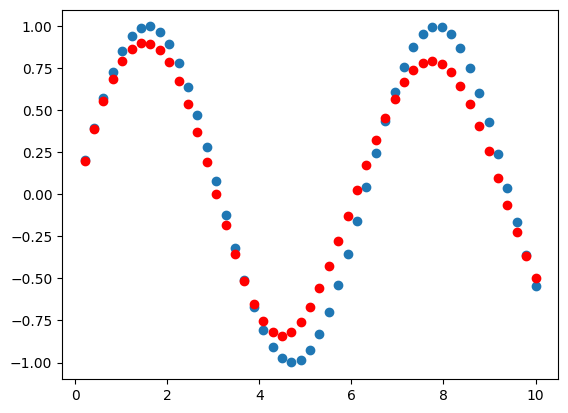

In [29]:
from matplotlib import pyplot as plt
# 先用同样的方式生成一组数据x,y
k = np.random.randint(3, size=1)[0]
time_steps = np.linspace(k, k + 10, num_points)
data = np.sin(time_steps)
data = data.reshape(num_points, 1)  # feature_len=1
x = torch.tensor(data[:-1]).float().view(1, seq_len, 1)  # batch,seq_len,feature_len
y = torch.tensor(data[1:]).float().view(1, seq_len, 1)  # batch,seq_len,feature_len

# 用于记录预测出的点
predictions = []

# 取训练时输入的第一个点,即在x(1,seq_len,1)取seq_len里面第0号的数据
# 这里将输入seq_len'设置为1(而不是49)
# 输入什么长度的数据会自动调整网络结构来给出输出
input = x[:, 0, :]
# 输入的shape变成标准的(batch=1,seq_len'=1,feature_len=1)
input = input.view(1, 1, 1)

# 迭代seq_len次,每次预测出一个点
for _ in range(x.shape[1]):
    # 送入模型得到预测的序列，输入了一个点的序列也就输出了(下)一个点的序列
    pred, h = model(input, h)
    # 这里将预测出的(下一个点的)序列pred当成输入,来给到下一次循环
    input = pred
    # 把里面那个点的数取出来记录到列表里
    # 这里用ravel()而不用flatten(),因为后者是原地操作,会改变pred也就是input
    predictions.append(pred.detach().data.numpy().ravel()[0])

# 绘制预测结果predictions和真实结果y的比较
plt.scatter(time_steps[1:], y.data.numpy().ravel())
plt.scatter(time_steps[1:], predictions, c='r')
plt.show()
